In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

# Vizualise

> Here, we see experiment results!

- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp visualize

In [ ]:
#| hide

import json
from claimdb.configuration import *
from claimdb.transformation import *

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import seaborn as sns

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

## Re-run Bad Cases

Here, we will re-run some cases where we suspect the `LiteLLM` framework to have failed as an intermediary. Also, since we have custom logic for structured output extraction (we dont use the official APIs) we need to be extra careful and re-run cases where it is clear that outside factors produced the error and not the LLM (this is rare but can happen).

In [ ]:
#| export
#| hide

import json
from dbverify.configuration import config

In [ ]:
model = 'gpt-oss:20b'

fix_path = config.experiments_dir_pub / f"{model}.jsonl"

In [ ]:
correct_experiments = []
errs = []
total = 0

seen = []

with open(fix_path, 'r') as f:
    for line in f:
        total += 1
        parsed = json.loads(line)
        if parsed['claim_id'] in seen:
            print("Duplicate:", parsed['claim_id'])
            continue

        seen.append(parsed['claim_id'])

        if "(SQLITE_BUSY)" in line:
            errs.append(parsed)
            continue
        if '"An error occurred while running the tool. Please try again. Error: "' in line:
            errs.append(parsed)
            continue

        if "error" in parsed:
            if parsed['error'] == "JSON Extraction Error.":
                errs.append(parsed)
                continue
            if "status_code: " in parsed['error']:
                errs.append(parsed)
                continue
            if "Exceeded maximum retries (20) for output" in parsed['error']:
                errs.append(parsed)
                continue
            if "The next tool call(s) would exceed the tool_calls_limit" in parsed['error']:
                errs.append(parsed)
                continue
            if "Max turns (20) exceeded" in parsed['error']:
                errs.append(parsed)
                continue
            if "Error code: " in parsed['error']:
                errs.append(parsed)
                continue
            if "exceeded max retries count of 10" in parsed['error']:
                errs.append(parsed)
                continue

        correct_experiments.append(parsed)

survived = len(correct_experiments)

In [ ]:
print(f"Total: {total}, Survived: {survived}, Will Re-Run: {total - survived}")

Total: 674, Survived: 673, Will Re-Run: 1


In [ ]:
import random 

random.shuffle(correct_experiments)

In [ ]:
with open(fix_path, 'w') as f:
    for entry in correct_experiments:
        f.write(json.dumps(entry) + '\n')

## Results

### High-Level Overview

In [ ]:
#| export
with open(config.output_data_dir / 'all_claims_judged.jsonl', "r") as f:
    all_claims = [json.loads(line) for line in f]

    claim_map = {
        item['claim_id']: item for item in all_claims
    }

#### Load

In [ ]:
#| export
def load_df(model_name, path=None):
    predicted_results = []

    if path: p = path
    else: p = config.experiments_dir_pub / f"{model_name}.jsonl"

    with open(p, "r") as f:
        for line in f:

            log = json.loads(line)
            claim_id = log['claim_id']
            if claim_id not in claim_map: continue
            verdict = log['verdict']

            category = claim_map[claim_id].get('category', None)
            ground_truth = claim_map[claim_id]['label']
            db_name = claim_map[claim_id]['db_name']

            # Tool Calls
            num_tool_calls = None
            
            if "model_settings" in log and  not "error" in log:  # Means we are in OpenAI's SDK
                num_tool_calls = 0
                for item in log['to_input_list']:
                    if item.get('type', None) == 'function_call':
                        num_tool_calls += 1

            if "model_settings" not in log and not "error" in log:  # Means we are in Pydantic's Agents
                if log.get("error", None): 
                    num_tool_calls = None
                    continue
                num_tool_calls = 0
                for message in log.get('all_messages', []):
                    # Check if this is a response message
                    if message.get('kind') == 'response':
                        # Look through the parts for tool calls
                        for part in message.get('parts', []):
                            if part.get('part_kind') == 'tool-call':
                                num_tool_calls += 1

            entry = {
                'claim_id': claim_id,
                'verdict': verdict,
                'ground_truth': ground_truth,
                'category': category,
                'db_name': db_name,
                'tool_calls': num_tool_calls
            }

            predicted_results.append(entry)
    
    df = pd.DataFrame(predicted_results)
    df['correct'] = df['verdict'] == df['ground_truth']

    return df

### Analyze

In [ ]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix
)

def find_statistics(df):

    labels = ["ENTAILED", "CONTRADICTED", "NOT ENOUGH INFO"]

    # Accuracy
    acc = accuracy_score(df["ground_truth"], df["verdict"])

    # Per-class precision / recall / F1
    P, R, F1, support = precision_recall_fscore_support(
        df["ground_truth"],
        df["verdict"],
        labels=labels,
        zero_division=0
    )

    metrics = {
        label: {
            "precision": P[i],
            "recall": R[i],
            "f1": F1[i],
            "support": support[i],
        }
        for i, label in enumerate(labels)
    }

    # Macro-F1
    macro_f1 = F1.mean()

    # Confusion matrix
    cm = confusion_matrix(
        df["ground_truth"],
        df["verdict"],
        labels=labels
    )

    return acc, metrics, macro_f1, cm

### Latex Prints

In [ ]:
def print_latex_tab(model, acc, metrics, macro_f1):
    ent = metrics['ENTAILED']
    contr = metrics['CONTRADICTED']
    nei = metrics['NOT ENOUGH INFO']

    print(
        f"\\texttt{{{model}}}\n"
        f"& \\gray{{ {ent['precision']:.3f} }} & \\gray{{ {contr['precision']:.3f} }} & \\gray{{ {nei['precision']:.3f} }}\n"
        f"& \\gray{{ {ent['recall']:.3f} }} & \\gray{{ {contr['recall']:.3f} }} & \\gray{{ {nei['recall']:.3f} }}\n"
        f"& {ent['f1']:.3f} & {contr['f1']:.3f} & {nei['f1']:.3f}\n"
        f"& {macro_f1:.3f} & {acc:.3f} \\\\"
    )

### Load Up

In [ ]:
models = [
    'gpt-4o-mini',
    'gpt-4.1-nano',
    'gpt-5-nano',
    'gpt-5-mini',
    'gpt-oss:20b',
    'gemini-2.5-flash',
    'gemini-3-flash-preview',
    'claude-3-haiku-20240307',
    'claude-3-5-haiku-20241022',
    'claude-haiku-4-5',
    'qwen3:1.7b',
    'qwen3:4b',
    'qwen3:8b',
    'qwen3:14b',
    'qwen3:32b',
    'qwen3-coder:30b',
    'ministral-3:3b',
    'ministral-3:8b',
    'ministral-3:14b',
    'mistral-nemo:12b',
    'mistral-small:22b',
    'magistral:24b',
    'devstral:24b',
    'devstral-small-2:24b',
    'nemotron-3-nano',
    'llama3.1:8b',
    'llama3.2:3b',
    'cogito:14b',
    'cogito:32b',
    'qwq:32b',
]

info_dict = {
    'gpt-4o-mini': {'name': 'gpt-4o-mini', 'params': None, 'creator': 'OpenAI'},
    'gpt-4.1-nano': {'name': 'gpt-4.1-nano', 'params': None, 'creator': 'OpenAI'},
    'gpt-5-nano': {'name': 'gpt-4.1-nano', 'params': None, 'creator': 'OpenAI'},
    'gpt-5-mini': {'name': 'gpt-5-mini', 'params': None, 'creator': 'OpenAI'},
    'gpt-oss:20b': {'name': 'gpt-oss', 'params': 20, 'creator': 'OpenAI'},
    'gemini-2.5-flash': {'name': 'gemini-2.5-flash', 'params': None, 'creator': 'Google'},
    'gemini-3-flash-preview': {'name': 'gemini-3-flash', 'params': None, 'creator': 'Google'},
    'claude-3-haiku-20240307': {'name': 'claude-3-haiku', 'params': None, 'creator': 'Anthropic'},
    'claude-3-5-haiku-20241022': {'name': 'claude-3-5-haiku', 'params': None, 'creator': 'Anthropic'},
    'claude-haiku-4-5': {'name': 'claude-haiku-4-5', 'params': None, 'creator': 'Anthropic'},
    'qwen3:1.7b': {'name': 'qwen3', 'params': 1.7, 'creator': 'Alibaba'},
    'qwen3:4b': {'name': 'qwen3', 'params': 4, 'creator': 'Alibaba'},
    'qwen3:8b': {'name': 'qwen3', 'params': 8, 'creator': 'Alibaba'},
    'qwen3:14b': {'name': 'qwen3', 'params': 14, 'creator': 'Alibaba'},
    'qwen3:32b': {'name': 'qwen3', 'params': 32, 'creator': 'Alibaba'},
    'qwen3-coder:30b': {'name': 'qwen3-coder', 'params': 30, 'creator': 'Alibaba'},
    'ministral-3:3b': {'name': 'ministral-3', 'params': 3, 'creator': 'Mistral AI'},
    'ministral-3:8b': {'name': 'ministral-3', 'params': 8 , 'creator': 'Mistral AI'},
    'ministral-3:14b': {'name': 'ministral-3', 'params': 14, 'creator': 'Mistral AI'},
    'mistral-small:22b': {'name': 'mistral-small', 'params': 22, 'creator': 'Mistral AI'},
    'magistral:24b': {'name': 'magistral', 'params': 24, 'creator': 'Mistral AI'},
    'mistral-nemo:12b': {'name': 'mistral-nemo', 'params': 12, 'creator': 'Mistral AI'},
    'devstral:24b': {'name': 'devstral', 'params': 24, 'creator': 'Mistral AI'},
    'devstral-small-2:24b': {'name': 'devstral-small-2', 'params': 24, 'creator': 'Mistral AI'},
    'nemotron-3-nano': {'name': 'nemotron-3-nano', 'params': 30, 'creator': 'NVIDIA'},
    'llama3.1:8b': {'name': 'llama3.1', 'params': 8, 'creator': 'Meta'},
    'llama3.2:3b': {'name': 'llama3.2', 'params': 3, 'creator': 'Meta'},
    'cogito:14b': {'name': 'cogito', 'params': 14, 'creator': 'Deep Cogito'},
    'cogito:32b': {'name': 'cogito', 'params': 32, 'creator': 'Deep Cogito'},
    'qwq:32b': {'name': 'qwq', 'params': 32, 'creator': 'Alibaba'},
}

In [ ]:
len(info_dict)

30

In [ ]:
model_results = dict()
model_dfs = []
for model in models[::-1]:
    df = load_df(model)
    df['model'] = model
    model_dfs.append(df)
    acc, metrics, macro_f1, cm = find_statistics(df)
    model_results[model] = {
        "accuracy": acc,
        "metrics": metrics,
        "macro_f1": macro_f1,
        "confusion_matrix": cm
    }
    print_latex_tab(model, acc, metrics, macro_f1)
    #print()

df = pd.concat(model_dfs)

\texttt{qwq:32b}
& \gray{ 0.500 } & \gray{ 0.558 } & \gray{ 0.472 }
& \gray{ 0.336 } & \gray{ 0.508 } & \gray{ 0.667 }
& 0.402 & 0.532 & 0.552
& 0.495 & 0.504 \\
\texttt{cogito:32b}
& \gray{ 0.797 } & \gray{ 0.564 } & \gray{ 0.506 }
& \gray{ 0.354 } & \gray{ 0.556 } & \gray{ 0.792 }
& 0.491 & 0.560 & 0.617
& 0.556 & 0.568 \\
\texttt{cogito:14b}
& \gray{ 0.758 } & \gray{ 0.701 } & \gray{ 0.384 }
& \gray{ 0.141 } & \gray{ 0.184 } & \gray{ 0.973 }
& 0.238 & 0.292 & 0.551
& 0.360 & 0.435 \\
\texttt{llama3.2:3b}
& \gray{ 0.428 } & \gray{ 0.412 } & \gray{ 0.366 }
& \gray{ 0.372 } & \gray{ 0.100 } & \gray{ 0.685 }
& 0.398 & 0.161 & 0.477
& 0.345 & 0.387 \\
\texttt{llama3.1:8b}
& \gray{ 0.341 } & \gray{ 0.433 } & \gray{ 0.337 }
& \gray{ 0.222 } & \gray{ 0.079 } & \gray{ 0.726 }
& 0.269 & 0.133 & 0.461
& 0.288 & 0.344 \\
\texttt{nemotron-3-nano}
& \gray{ 0.714 } & \gray{ 0.726 } & \gray{ 0.612 }
& \gray{ 0.652 } & \gray{ 0.601 } & \gray{ 0.747 }
& 0.681 & 0.658 & 0.673
& 0.671 & 0.667 \\
\textt

In [ ]:
## priv
"""
priv
\texttt{gpt-5-nano}
& \gray{ 0.808 } & \gray{ 0.721 } & \gray{ 0.879 }
& \gray{ 0.684 } & \gray{ 0.915 } & \gray{ 0.780 }
& 0.741 & 0.807 & 0.826
& 0.791 & 0.793 \\
"""

### Scaling Law Plot

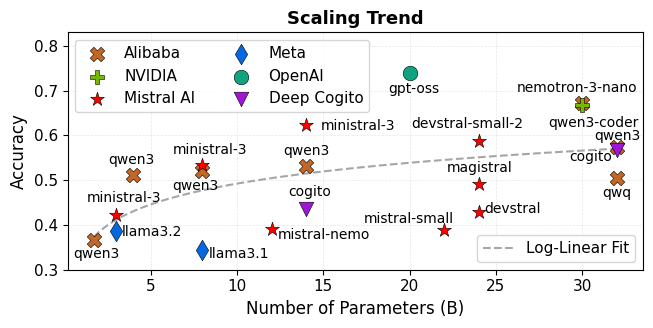

In [ ]:
from adjustText import adjust_text
import numpy as np

# Define markers and colors per creator
creator_styles = {
    'NVIDIA': {'marker': 'P', 'color': '#76b900'},
    'OpenAI': {'marker': 'o', 'color': '#10a37f'},
    'Google': {'marker': 's', 'color': '#4285f4'},
    'Anthropic': {'marker': '^', 'color': '#d4a574'},
    'Alibaba': {'marker': 'X', 'color': "#c46724"},
    'Mistral AI': {'marker': '*', 'color': "#ff0000"},
    'Meta': {'marker': 'd', 'color': '#0668e1'},
    'Deep Cogito': {'marker': 'v', 'color': "#a115d8"},
}

def plot_models_scatter(official_names, num_params_list, accuracies, creators, *, adjust_text_dict=None, title=None):
    fig, ax = plt.subplots(figsize=(6.75, 3.5))
    
    # Group by creator for legend
    plotted_creators = set()
    
    for official_name, num_params, accuracy, creator in zip(official_names, num_params_list, accuracies, creators):
        style = creator_styles.get(creator, {'marker': 'o', 'color': 'gray'})
        
        label = creator if creator not in plotted_creators else None
        plotted_creators.add(creator)
        
        ax.scatter(num_params, accuracy, s=110, marker=style['marker'], color=style['color'], 
                   label=label, zorder=5, edgecolors='black', linewidths=0.4)
    
    # Add trend line (logarithmic fit for scaling laws)
    x = np.array(num_params_list)
    y = np.array(accuracies)
    # Fit log curve: y = a * log(x) + b
    log_x = np.log(x)
    coeffs = np.polyfit(log_x, y, 1)
    # Generate smooth line
    x_smooth = np.linspace(x.min(), x.max(), 100)
    y_smooth = coeffs[0] * np.log(x_smooth) + coeffs[1]
    
    ax.plot(x_smooth, y_smooth, color='gray', linestyle='--', linewidth=1.5, 
            alpha=0.7, zorder=1,)#label='Log-Linear Fit')
        
    # Create text objects for adjustText
    texts = []
    for official_name, num_params, accuracy in zip(official_names, num_params_list, accuracies):
        
        model_name = info_dict[official_name]['name']
        par_text, acc_text = adjust_text_dict.get(official_name, (0.01, 0.01))
        
        texts.append(
            ax.text(num_params + par_text, accuracy + acc_text, model_name,
            fontsize=10, fontweight='medium')
        )

    # Automatically adjust text positions to avoid overlap
    adjust_text( texts, x=num_params_list, y=accuracies, ax=ax,)

    ax.set_xlabel("Number of Parameters (B)", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    if title:
        ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
    ax.tick_params(labelsize=11)
    ax.legend(loc='upper left', fontsize=11, markerscale=1., ncol=2)
    ax.set_ylim(0.3, 0.83)

    
    # Create two legends: one for creators (upper left), one for fit line (lower right)
    legend1 = ax.legend(loc='upper left', fontsize=11, markerscale=1., ncol=2)
    ax.add_artist(legend1)
    # Add second legend for the fit line at bottom right
    from matplotlib.lines import Line2D
    fit_line = Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.legend([fit_line], ['Log-Linear Fit'], loc='lower right', fontsize=11)

    #ax.margins(0.1)
    plt.tight_layout()
    plt.savefig(config.paper_plots_dir / 'scaling_trend.pdf', bbox_inches='tight')
    #ax.set_xscale("log")
    plt.show()


official_names = []
num_params_list = []
accuracies = []
creators = []
for official_name, results in list(sorted(model_results.items()))[::-1]:
    num_params = info_dict[official_name]['params']
    accuracy = results["accuracy"]
    creator = info_dict[official_name]['creator']
    if num_params is None:
        continue
    official_names.append(official_name)
    num_params_list.append(num_params)
    accuracies.append(accuracy)
    creators.append(creator)

# x, y
adjust_text_dict = {
    'qwen3:1.7b': (-1.3, -0.07),
    'ministral-3:3b': (-2., 0.023),
    'llama3.2:3b': (+0.1, -.018),
    'qwen3:4b': (-1.5, +0.02),
    'qwen3:8b': (-2, -0.03),
    'ministral-3:8b': (-2., +.02),
    'llama3.1:8b': (+0.1, -0.01),
    'ministral-3:14b': (+0.5, -0.0),
    'mistral-nemo:12b': (-0.5, -.01),
    'cogito:14b': (-1.2, +.025),
    'qwen3:14b': (-1.4, +0.02),
    'gpt-oss:20b': (-1.5, -0.034),
    'magistral:24b': (-2, +0.02),
    #'devstral:24b': (0, -0.03),
    'mistral-small:22b': (-5, +0.01),
    'devstral-small-2:24b': (-2.5, +0.02),
    'cogito:32b': (-3, -0.026),
    'nemotron-3-nano': (-1., +0.025),
    'qwen3-coder:30b': (-1, -0.07),
    'qwq:32b': (-1, -0.03),
}


plot_models_scatter(official_names, num_params_list, accuracies, creators, adjust_text_dict=adjust_text_dict, title="Scaling Trend")

## Similarity (+Embeddings)

### Load Embeddings

In [ ]:
with open(config.embeddings_dir / 'out_of_schema_claim_similarity.jsonl', 'r') as f:
    schema_sims = [json.loads(line) for line in f]

with open(config.embeddings_dir / 'counterfactual_claim_similarity.jsonl', 'r') as f:
    counterfactual_sims = [json.loads(line) for line in f]

df_schema_sims = pd.DataFrame(schema_sims)
df_counterfactual_sims = pd.DataFrame(counterfactual_sims)

### Similarity Plot

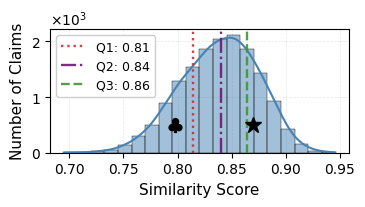

In [ ]:
# Single plot for Out-of-Schema - ACL single column format
fig, ax = plt.subplots(1, 1, figsize=(4, 2.3))

# Out-of-Schema histogram
sns.histplot(
    data=df_schema_sims['similarity'], 
    bins=20, 
    kde=True, 
    stat='count', 
    kde_kws={'bw_adjust': 1.5},
    color="steelblue",
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

# Add quantile lines
quantiles = [0.25, 0.5, 0.75]
colors = ['#d62728', '#6D1673', "#429632"]
labels = ['Q1', 'Q2', 'Q3']
linestyles = [':', 'dashdot', 'dashed']

for q, color, label, ls in zip(quantiles, colors, labels, linestyles):
    value = df_schema_sims['similarity'].quantile(q)
    ax.axvline(value, color=color, linestyle=ls, linewidth=1.7, 
               label=f'{label}: {value:.2f}', alpha=0.9)

# Add example markers
ax.plot(0.87, 500, marker='*', markersize=12, color='black')
ax.plot(0.798, 500, marker=r'$\clubsuit$', markersize=10, color='black')

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Similarity Score', fontsize=11)
ax.set_ylabel('Number of Claims', fontsize=11)
#ax.set_title('Out-of-Schema Claims', fontweight='bold', fontsize=11)
ax.legend(loc='upper left', framealpha=0.95, fontsize=9)
ax.tick_params(labelsize=10)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(10)

plt.tight_layout()
plt.savefig(config.paper_plots_dir / 'similarity_out_of_schema.pdf', bbox_inches='tight')
plt.show()

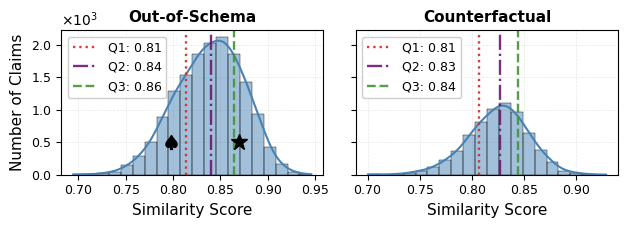

In [ ]:
# Create side-by-side plots for ACL double-column format
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2.5), sharey=True)

# LEFT PLOT: Out-of-Schema
sns.histplot(
    data=df_schema_sims['similarity'], 
    bins=20, 
    kde=True, 
    stat='count', 
    kde_kws={'bw_adjust': 1.5},
    color="steelblue",
    edgecolor="black",
    linewidth=0.3,
    ax=ax1
)

# Add quantile lines for schema
quantiles = [0.25, 0.5, 0.75]
colors = ['#d62728', '#6D1673', "#429632"]
labels = ['Q1', 'Q2', 'Q3']
linestyles = [':', 'dashdot', 'dashed']

for q, color, label, ls in zip(quantiles, colors, labels, linestyles):
    value = df_schema_sims['similarity'].quantile(q)
    ax1.axvline(value, color=color, linestyle=ls, linewidth=1.7, 
                label=f'{label}: {value:.2f}', alpha=0.9)
    
ax1.plot(0.87, 500, marker='*', markersize=12, color='black')
ax1.plot(0.798, 500, marker=r'$\spadesuit$', markersize=10, color='black')


ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_axisbelow(True)
ax1.set_xlabel('Similarity Score', fontsize=11)
ax1.set_ylabel('Number of Claims', fontsize=11)
ax1.set_title('Out-of-Schema', fontweight='bold', fontsize=11)
ax1.legend(loc='upper left', framealpha=0.95, fontsize=9)
ax1.tick_params(labelsize=9)
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)  # ADD THIS LINE
ax1.yaxis.get_offset_text().set_fontsize(10)  # Make the 1e3 smaller



# RIGHT PLOT: Counterfactual
sns.histplot(
    data=df_counterfactual_sims['similarity'], 
    bins=20, 
    kde=True, 
    stat='count', 
    kde_kws={'bw_adjust': 1.5},
    color='steelblue',
    edgecolor='black',
    linewidth=0.3,
    ax=ax2
)

# Add quantile lines for counterfactual
for q, color, label, ls in zip(quantiles, colors, labels, linestyles):
    value = df_counterfactual_sims['similarity'].quantile(q)
    ax2.axvline(value, color=color, linestyle=ls, linewidth=1.7, 
                label=f'{label}: {value:.2f}', alpha=0.9)

ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax2.set_axisbelow(True)
ax2.set_xlabel('Similarity Score', fontsize=11)
ax2.set_title('Counterfactual', fontweight='bold', fontsize=11)
ax2.legend(loc='upper left', framealpha=0.95, fontsize=9)
ax2.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig(config.paper_plots_dir / 'similarity_distributions.pdf', bbox_inches='tight')
plt.show()

## Tool Usage Analysis

In [ ]:
df_open = df[~df['tool_calls'].isna()]

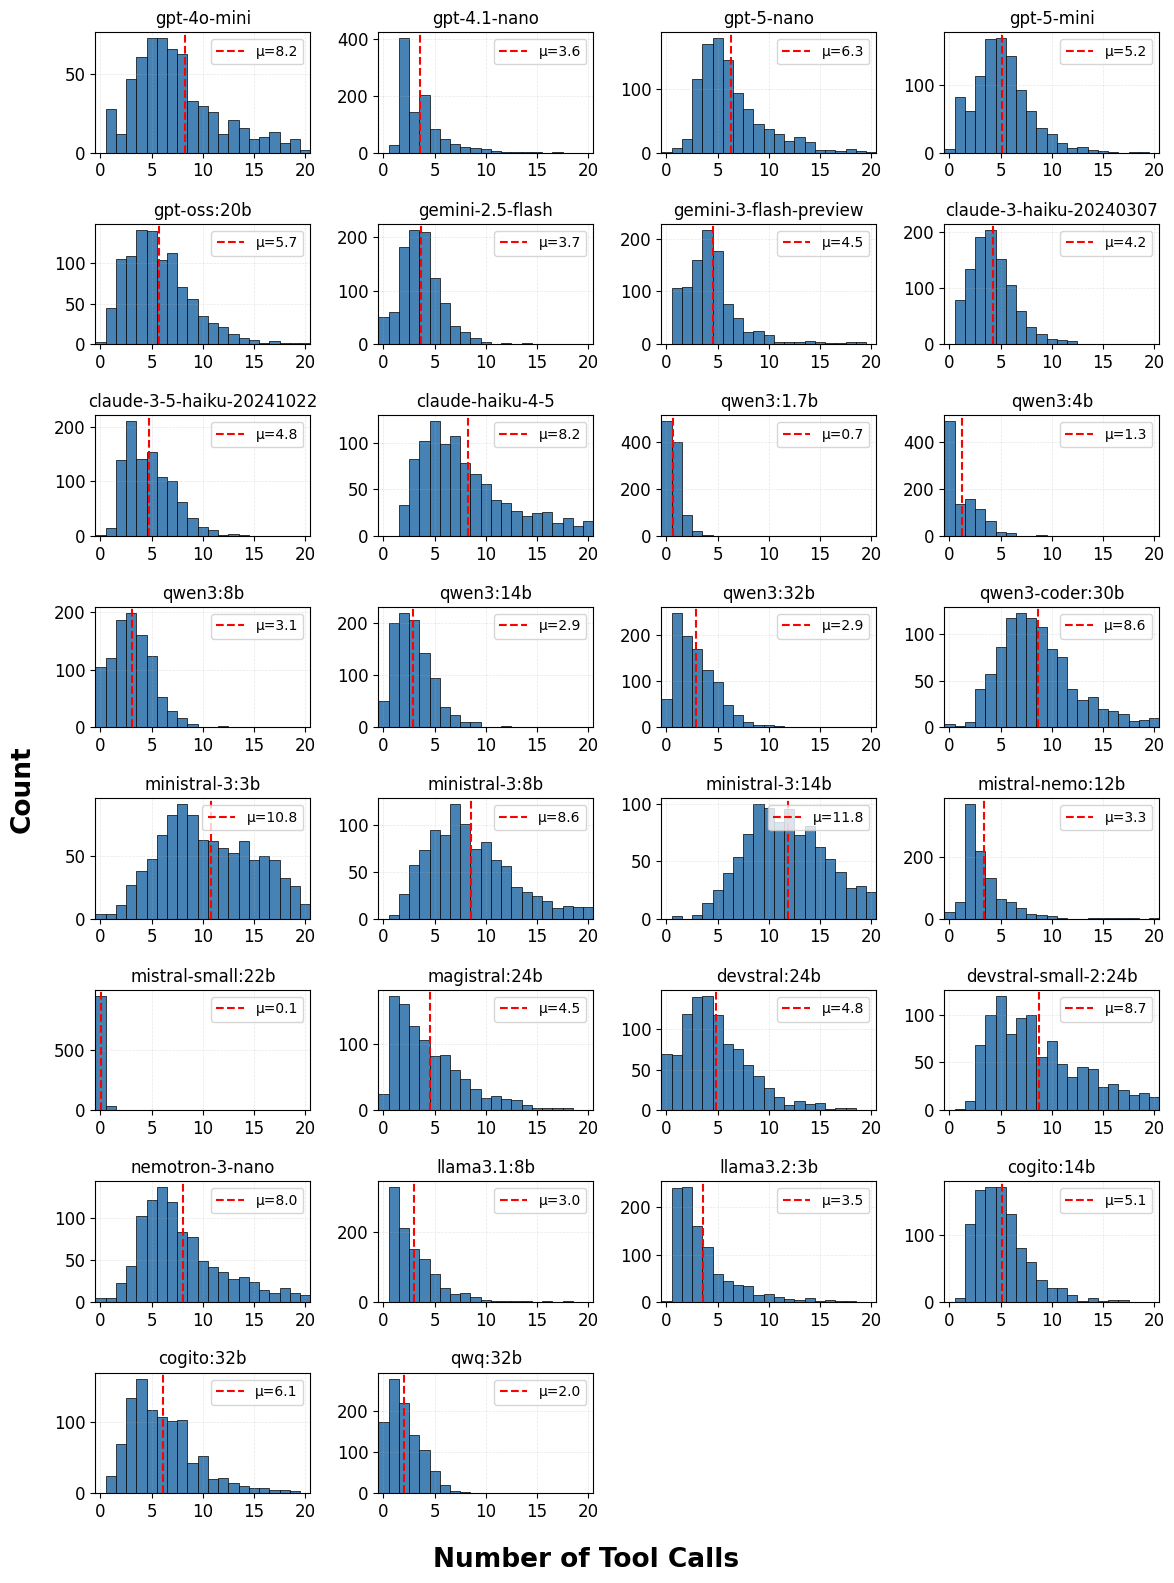

In [ ]:
# 8x4 grid of histograms for tool calls per model (30 models, so 8x4=32 slots)
fig, axes = plt.subplots(8, 4, figsize=(12, 16))
axes = axes.flatten()

bins = np.arange(0, 22) - 0.5  # 0-20 with 21 bins, centered on integers

for idx, model_name in enumerate(models):
    ax = axes[idx]
    model_data = df_open[df_open['model'] == model_name]['tool_calls']
    
    ax.hist(model_data, bins=bins, edgecolor='black', linewidth=0.5, color='steelblue')
    ax.set_title(model_name, fontsize=12, fontweight='light')
    ax.set_xlim(-0.5, 20.5)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.tick_params(labelsize=12)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add mean line
    mean_val = model_data.mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'μ={mean_val:.1f}')
    ax.legend(fontsize=10, loc='upper right')

# Hide unused subplots (30 models, 2 empty slots)
for idx in range(len(models), len(axes)):
    axes[idx].axis('off')

# Common labels
fig.supxlabel('Number of Tool Calls', fontsize=19, fontweight='bold')
fig.supylabel('Count', fontsize=19, fontweight='bold')
#fig.suptitle('Tool Call Distribution per Model', fontsize=16, fontweight='bold', fontweight='bold')

plt.tight_layout()
plt.savefig(config.paper_plots_dir / 'tool_calls_histograms.pdf', bbox_inches='tight')
plt.show()

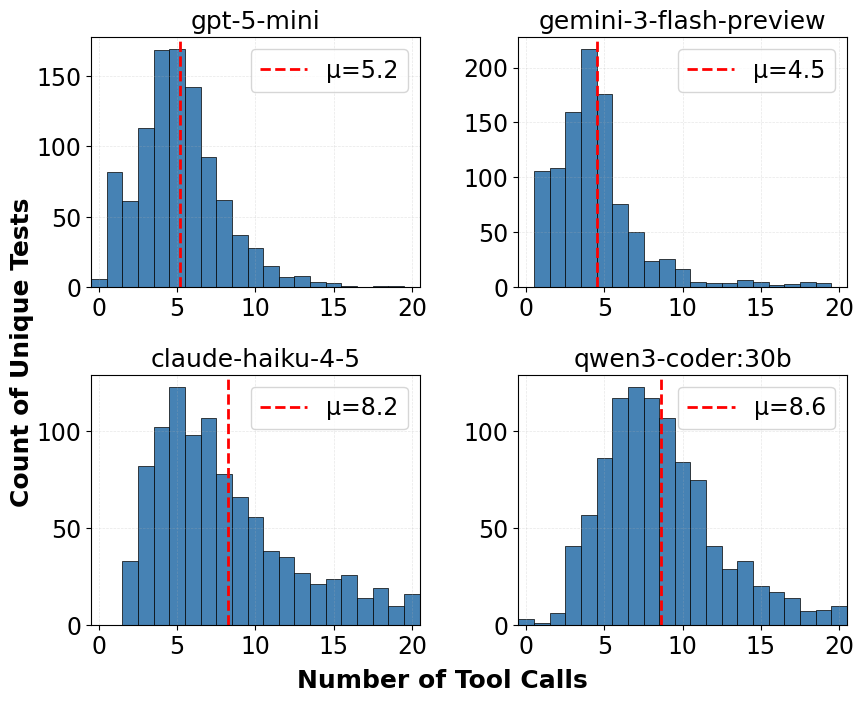

In [ ]:
# 2x2 grid of tool call histograms for selected models
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

#selected_models = ['gpt-5-mini', 'gemini-3-flash-preview', 'claude-haiku-4-5', 'qwen3-coder:30b']
bins = np.arange(0, 22) - 0.5  # 0-20 with 21 bins, centered on integers
selected_models = ['gpt-5-mini', 'gemini-3-flash-preview', 'claude-haiku-4-5', 'qwen3-coder:30b']


for idx, model_name in enumerate(selected_models):
    ax = axes[idx]
    model_data = df_open[df_open['model'] == model_name]['tool_calls']
    
    ax.hist(model_data, bins=bins, edgecolor='black', linewidth=0.5, color='steelblue')
    ax.set_title(model_name, fontsize=18, fontweight='light')
    ax.set_xlim(-0.5, 20.5)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.tick_params(labelsize=17)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add mean line
    mean_val = model_data.mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'μ={mean_val:.1f}')
    ax.legend(fontsize=17, loc='upper right')

# Common labels
fig.text(0.5, 0.02, 'Number of Tool Calls', fontweight='bold', ha='center', fontsize=18)
fig.text(0.02, 0.5, 'Count of Unique Tests', va='center', rotation='vertical', fontweight='bold', fontsize=18)

# Adjust layout manually
fig.subplots_adjust(left=0.11, right=0.95, top=0.95, bottom=0.11, wspace=0.3, hspace=0.35)

plt.savefig(config.paper_plots_dir / 'tool_calls_selected_four.pdf', bbox_inches='tight')
plt.show()

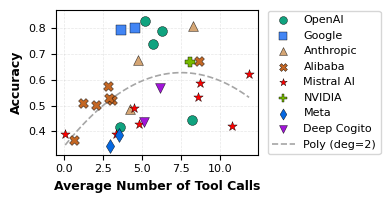

In [ ]:
fig, ax = plt.subplots(figsize=(4.15, 2.25))

# Calculate average tool calls and accuracy per model
avg_tool_calls = []
accuracies = []
model_names = []

for model_name in models:
    model_data = df_open[df_open['model'] == model_name]
    if len(model_data) > 0:
        avg_tc = model_data['tool_calls'].mean()
        acc = model_results[model_name]['accuracy']
        avg_tool_calls.append(avg_tc)
        accuracies.append(acc)
        model_names.append(model_name)

# Get creator info for coloring
creators = [info_dict[m]['creator'] for m in model_names]

# Plot each point with creator-specific styling
plotted_creators = set()
for model_name, avg_tc, acc, creator in zip(model_names, avg_tool_calls, accuracies, creators):
    style = creator_styles.get(creator, {'marker': 'o', 'color': 'gray'})
    label = creator if creator not in plotted_creators else None
    plotted_creators.add(creator)
    
    ax.scatter(avg_tc, acc, s=50, marker=style['marker'], color=style['color'],
               label=label, edgecolors='black', linewidths=0.3, zorder=5)

# Add polynomial trend line
x = np.array(avg_tool_calls)
y = np.array(accuracies)
degree = 2
coeffs = np.polyfit(x, y, degree)
poly = np.poly1d(coeffs)

# Generate smooth line
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = poly(x_smooth)

ax.plot(x_smooth, y_smooth, color='gray', linestyle='--', linewidth=1.2, 
        alpha=0.7, zorder=1, label='Poly (deg=2)')

ax.set_xlabel('Average Number of Tool Calls', fontsize=9, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=9, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(labelsize=8)
ax.set_ylim(0.31, 0.87)

# Legend outside on the right
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8, markerscale=0.8)

plt.tight_layout()
plt.savefig(config.paper_plots_dir / 'tool_calls_vs_accuracy_compact.pdf', bbox_inches='tight')
plt.show()

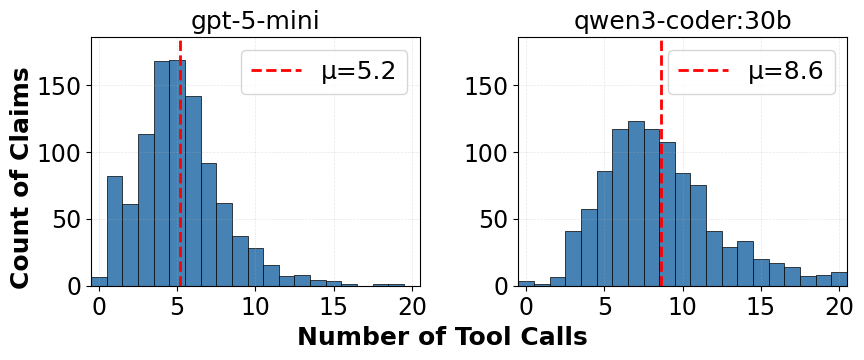

In [ ]:
# 1x2 grid of tool call histograms for selected models
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))

selected_models = ['gpt-5-mini', 'qwen3-coder:30b']
bins = np.arange(0, 22) - 0.5  # 0-20 with 21 bins, centered on integers

# Find global y-max for consistent scale
y_max = 0
for model_name in selected_models:
    model_data = df_open[df_open['model'] == model_name]['tool_calls']
    counts, _ = np.histogram(model_data, bins=bins)
    y_max = max(y_max, counts.max())

for idx, model_name in enumerate(selected_models):
    ax = axes[idx]
    model_data = df_open[df_open['model'] == model_name]['tool_calls']
    
    ax.hist(model_data, bins=bins, edgecolor='black', linewidth=0.5, color='steelblue')
    ax.set_title(model_name, fontsize=18, fontweight='light')
    ax.set_xlim(-0.5, 20.5)
    ax.set_ylim(0, y_max * 1.1)  # Set same y-limit for both
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.tick_params(labelsize=17)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add mean line
    mean_val = model_data.mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'μ={mean_val:.1f}')
    ax.legend(fontsize=18, loc='upper right')

# Common labels
fig.text(0.5, 0.02, 'Number of Tool Calls', fontweight='bold', ha='center', fontsize=18)
fig.text(0.02, 0.5, 'Count of Claims', va='center', rotation='vertical', fontweight='bold', fontsize=18)

# Adjust layout manually
fig.subplots_adjust(left=0.11, right=0.95, top=0.9, bottom=0.19, wspace=0.3)

plt.savefig(config.paper_plots_dir / 'tool_calls_selected.pdf', bbox_inches='tight')
plt.show()

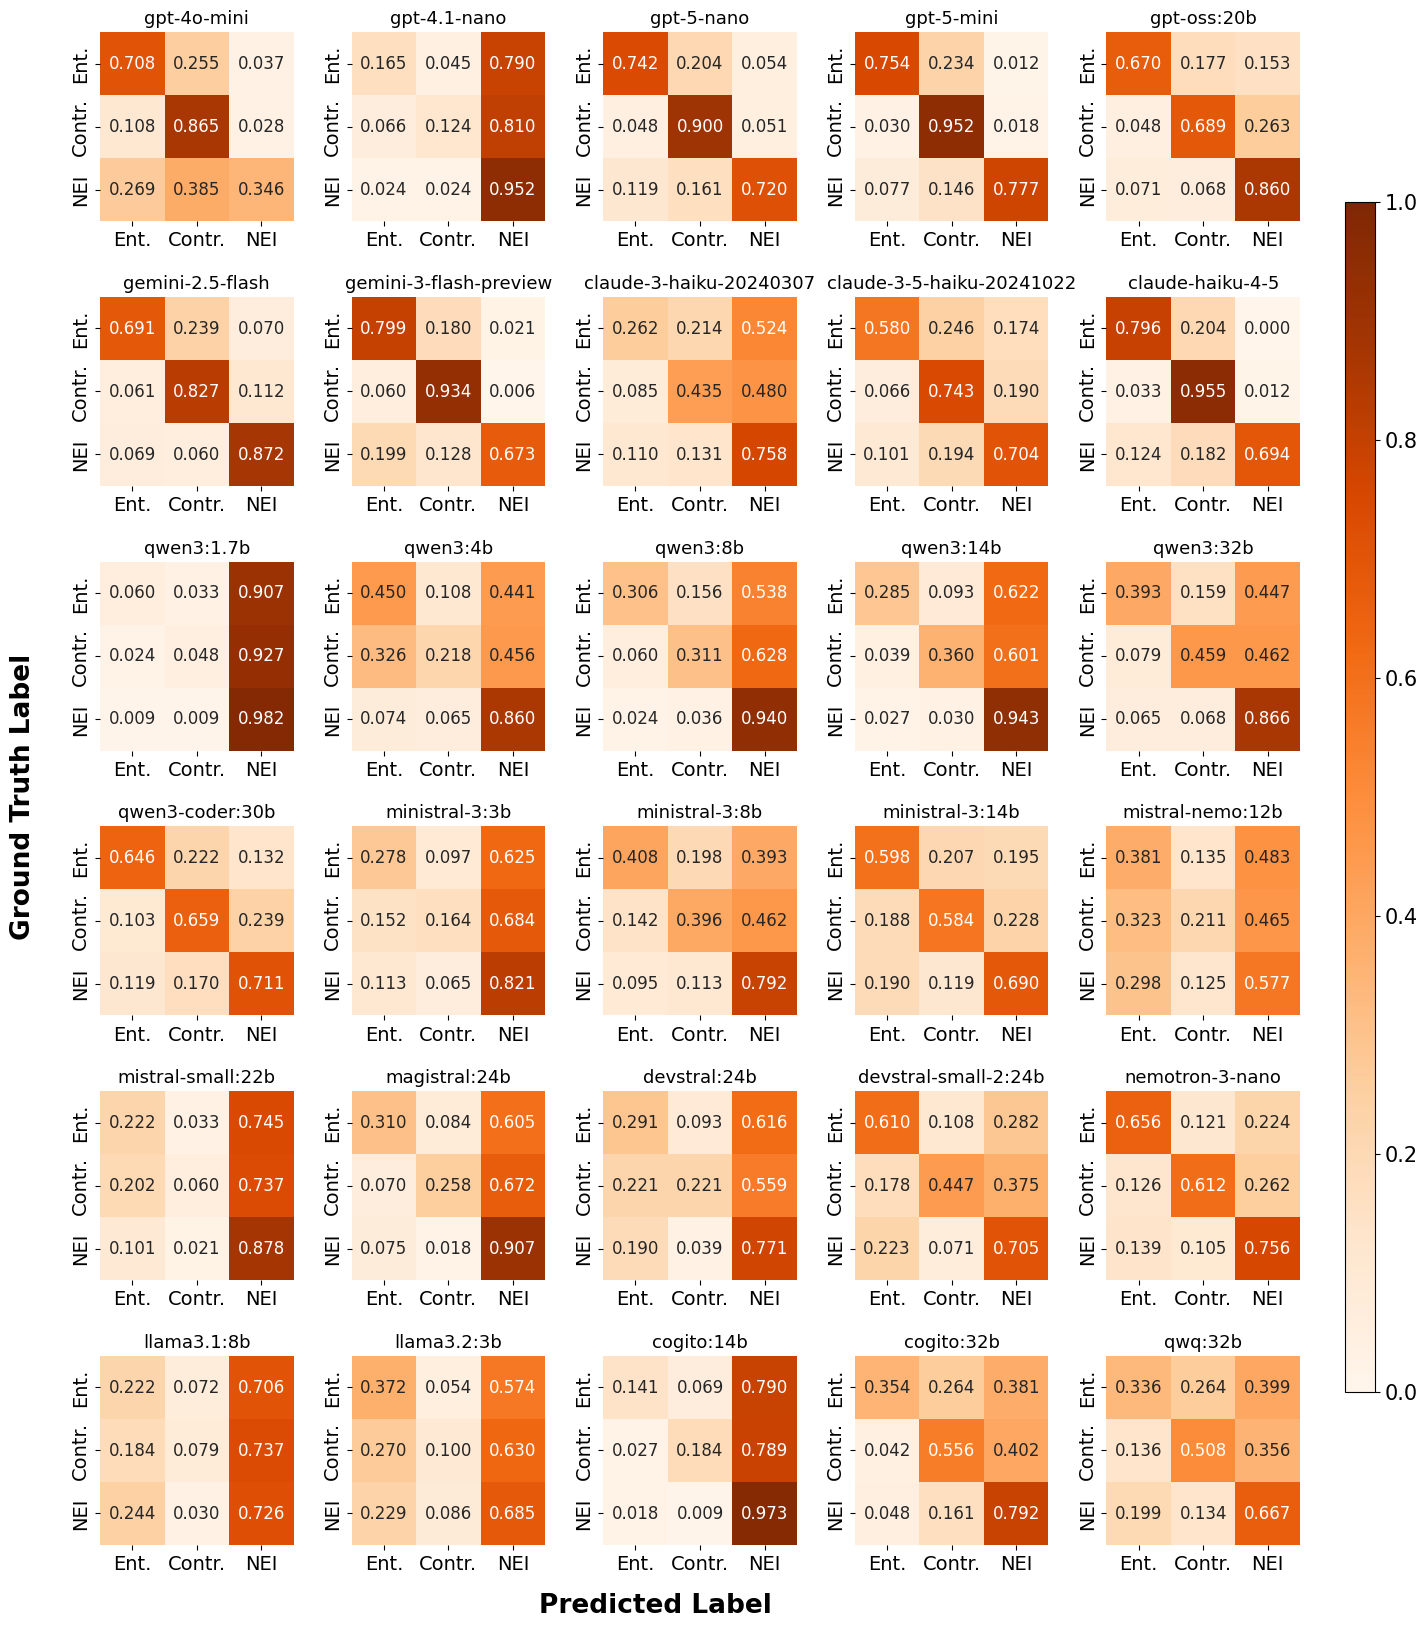

In [ ]:
# 6x5 grid of confusion matrices for each model (30 models, so 6x5=30 slots)
fig, axes = plt.subplots(6, 5, figsize=(15, 17))
axes = axes.flatten()

labels = ["Ent.", "Contr.", "NEI"]  # Shortened for display

for idx, model_name in enumerate(models):
    ax = axes[idx]
    cm = model_results[model_name]['confusion_matrix']
    
    # Normalize by row (true labels) to show recall per class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap with orange colormap (no individual colorbars)
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt='.3f', 
        cmap='Oranges',
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        cbar=False,  # Disable individual colorbars
        vmin=0, 
        vmax=1,
        annot_kws={'fontsize': 12}
    )
    
    ax.set_title(model_name, fontsize=13, fontweight='light')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=14)
    
    # Fix rotations: x-axis horizontal (0), y-axis horizontal (0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

# Hide unused subplots
for idx in range(len(models), len(axes)):
    axes[idx].axis('off')

# Common labels
fig.text(0.45, 0.02, 'Predicted Label', fontweight='bold', ha='center', fontsize=19)
fig.text(0.02, 0.5, 'Ground Truth Label', va='center', rotation='vertical', fontweight='bold', fontsize=19)

# Adjust layout manually to leave space for colorbar
fig.subplots_adjust(left=0.08, right=0.88, top=0.95, bottom=0.06, wspace=0.3, hspace=0.4)

# Add single shared colorbar on the right
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)

plt.savefig(config.paper_plots_dir / 'confusion_matrices_grid.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# 2x2 grid of confusion matrices for selected models with single shared colorbar
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

selected_models = ['gpt-5-mini', 'claude-haiku-4-5', 'qwen3:32b', 'nemotron-3-nano']
labels = ["Ent.", "Contr.", "NEI"]  # Shortened for display

for idx, model_name in enumerate(selected_models):
    ax = axes[idx]
    cm = model_results[model_name]['confusion_matrix']
    
    # Normalize by row (true labels) to show recall per class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap with orange colormap (no individual colorbars)
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt='.3f', 
        cmap='Oranges',
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        cbar=False,  # Disable individual colorbars
        vmin=0, 
        vmax=1,
        annot_kws={'fontsize': 17}
    )
    
    #ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.set_title(model_name, fontsize=18, fontweight='light')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=17)

# Common labels
fig.text(0.48, 0.02, 'Predicted Label', fontweight='bold', ha='center', fontsize=18)
fig.text(0.02, 0.5, 'Ground Truth Label', va='center', rotation='vertical', fontweight='bold', fontsize=18)
#fig.suptitle('Confusion Matrices (Normalized)', fontsize=15, fontweight='bold', y=0.98)

# Adjust layout manually to leave space for colorbar
fig.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.3, hspace=0.35)

# Add single shared colorbar on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=17)

plt.savefig(config.paper_plots_dir / 'confusion_matrices_selected.pdf', bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

## Find Total Cost

In [ ]:
model = 'gpt-5-nano'

In [ ]:
logs = config.experiments_log_dir / model
experiments = list(logs.glob("*"))

In [ ]:
regular_input_tokens = 0
cached_input_tokens = 0
output_tokens = 0

for exp in experiments:
    data = json.loads(exp.read_text())

    for response_usage in data['usage']:
        regular_input_tokens += response_usage['regular_input_tokens']
        cached_input_tokens += response_usage['cached_input_tokens']
        output_tokens += response_usage['output_tokens']


In [ ]:
regular_input_cost = regular_input_tokens * openai_costs[model]['regular_input_token']
cached_input_cost = cached_input_tokens * openai_costs[model]['cached_input_token']
output_cost = output_tokens * openai_costs[model]['output_token']
total_cost = regular_input_cost + cached_input_cost + output_cost

We divide by 2 because we use batch API

In [ ]:
print(f"Regular Input Cost: ${regular_input_cost:.2f}")
print(f"Cached Input Cost: ${cached_input_cost:.2f}")
print(f"Output Cost: ${output_cost:.2f}")
print(f"Total Cost: ${total_cost:.2f}")

Regular Input Cost: $39.01
Cached Input Cost: $1.07
Output Cost: $60.56
Total Cost: $100.63


## Dataset Creation Cost 

In [ ]:
model = 'gpt-5'

In [ ]:
input_tokens = 0
output_tokens = 0

with open(config.output_data_dir / 'openai_raw_results.txt', "r") as f:
    data = [line for line in f.read().splitlines()]

    for item in data:
        _, _, claim_collection_parsed = claim_collection_json_to_parsed(json.loads(item))
        input_tokens += claim_collection_parsed.usage.input_tokens
        output_tokens += claim_collection_parsed.usage.output_tokens

In [ ]:
input_cost = input_tokens * openai_costs[model]['regular_input_token'] / 2
output_cost = output_tokens * openai_costs[model]['output_token'] / 2
cost = input_cost + output_cost
print(f"Input Cost: ${input_cost:.2f} , Output Cost: ${output_cost:.2f}")
print(f"Total cost: ${cost:.2f}")

Input Cost: $9.87 , Output Cost: $135.88
Total cost: $145.74


### Mini-investigation on Nulls: We are ok!

In [ ]:
with open(config.final_benchmark_dir / 'test-public.jsonl', 'r') as f:
    benchmark = [json.loads(line)['bird_id'] for line in f.readlines()]
dev_results = []
ids = []

with open(config.bird_dir / 'train_dev_filtered.jsonl', 'r') as f:
    for line in f:
        parsed = json.loads(line)
        if parsed['bird_id'] in benchmark:
            ids.append(parsed['bird_id'])
            dev_results.append(json.dumps(parsed['result']))
for i, r in zip(ids, dev_results):
    if 'null' in r:
        print(i)

25
36
57
88
637


## ClaimDB Statistics

### Labels

In [ ]:
import tqdm

In [ ]:
with open(config.final_benchmark_dir / 'train.jsonl', 'r') as f:
    benchmark = [json.loads(line) for line in f.readlines()]

# this will fail -- not available publicly
with open(config.final_benchmark_dir / 'test-private-with-labels.jsonl', 'r') as f:
    benchmark.extend([json.loads(line) for line in f.readlines()])

with open(config.final_benchmark_dir / 'test-public.jsonl', 'r') as f:
    benchmark.extend([json.loads(line) for line in f.readlines()])

bird_id_dict = dict()
with open(config.bird_dir / 'train_dev_filtered.jsonl', 'r') as f:
    bird_id_dict = {
        json.loads(line)['bird_id']: json.loads(line) for line in f
    }

In [ ]:
ent, cont, nei, nei_schema, nei_counterfactual, nei_subjective = 0, 0, 0, 0, 0, 0

for claim_bucket in benchmark:
    label = claim_bucket['label']
    category = claim_bucket.get('category', None)

    if label == 'ENTAILED':
        ent += 1
    elif label == 'CONTRADICTED':
        cont += 1
    elif label == 'NOT ENOUGH INFO':
        nei += 1
        if category == 'OUT-OF-SCHEMA':
            nei_schema += 1
        elif category == 'COUNTERFACTUAL':
            nei_counterfactual += 1
        elif category == 'SUBJECTIVE':
            nei_subjective += 1

In [ ]:
print(f"Total Claims in Benchmark: {len(benchmark)}")
print(f"ENTAILED: {ent}")
print(f"CONTRADICTED: {cont}")
print(f"NOT ENOUGH INFO: {nei}")
print(f"  - OUT-OF-SCHEMA: {nei_schema}")
print(f"  - COUNTERFACTUAL: {nei_counterfactual}")
print(f"  - SUBJECTIVE: {nei_subjective}")

Total Claims in Benchmark: 53368
ENTAILED: 12855
CONTRADICTED: 16529
NOT ENOUGH INFO: 23984
  - OUT-OF-SCHEMA: 12644
  - COUNTERFACTUAL: 5786
  - SUBJECTIVE: 5554


### proper: Avg Tables Per Claim

In [ ]:
import sqlglot
from sqlglot import exp

def count_tables(sql: str) -> int:
    tree = sqlglot.parse_one(sql, read="mysql")
    tables = tree.find_all(exp.Table)
    return len({t.name for t in tables})  # unique tables

In [ ]:
sql = """
SELECT *
FROM orders o
JOIN customers c ON o.customer_id = c.id
JOIN regions r ON c.region_id = r.id
"""

count_tables(sql)

3

In [ ]:
total_tables = 0
total = 0
for claim_bucket in tqdm.tqdm(benchmark):
    bird_id = claim_bucket['bird_id']
    sql = bird_id_dict[bird_id]['SQL']
    sql = sql.replace("AS REL", "AS REAL")
    total_tables += count_tables(sql)
    total += 1

100%|██████████| 53370/53370 [00:14<00:00, 3804.08it/s]


In [ ]:
print(f"Average Evidence per Claim: {total_tables / total:.2f}")

Average Evidence per Claim: 2.09


### Databases

In [ ]:
unique_databases = set()

for claim_bucket in benchmark:
    unique_databases.add(claim_bucket['db_name'])

db_info = {dn_name: dict() for dn_name in unique_databases}
len(unique_databases)

80

In [ ]:
from dbverify.dbops import sqlite_execute_with_timeout

#### How many tables/rows/dbs you need to look for a single claim ver?

In [ ]:
user_defined_tables_query = """
SELECT name
FROM sqlite_master
WHERE type = 'table'
  AND name NOT LIKE 'sqlite_%';
"""

In [ ]:
for db_name in tqdm.tqdm(unique_databases):
    db_path = config.bird_databases_dir / db_name / f'{db_name}.sqlite'
    result = sqlite_execute_with_timeout(db_path, user_defined_tables_query)
    db_info[db_name]['num_tables'] = len(result)

    tables_info = dict()
    for row in result:
        table = row['name']
        table_count_query = f"SELECT COUNT(*) as C FROM '{table}';"
        table_count_result = sqlite_execute_with_timeout(db_path, table_count_query)
        tables_info[table] = table_count_result[0]['C']
    
    db_info[db_name]['tables'] = tables_info
        

100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


In [ ]:
tables_needed = 0
rows_needed = 0
total = 0
for claim_bucket in benchmark:
    db_name = claim_bucket['db_name']
    tables_needed += db_info[db_name]['num_tables']

    for name, count in db_info[db_name]['tables'].items():
        rows_needed += count

    total += 1

print(f"Average Tables Avail per Claim: {tables_needed / total:.2f}")
print(f"Average Rows Avail per Claim: {rows_needed / total:.2f}")

Average Tables Avail per Claim: 11.56
Average Rows Avail per Claim: 4645832.21


In [ ]:
rows = 0
num_dbs = len(db_info)
total_tables = 0
for db, info in db_info.items():
    for name, count in info['tables'].items():
        rows += count
        total_tables += 1


print(f"Average Tables per DB: {total_tables / num_dbs:.2f}")
print(f"Average Rows per DB: {rows / num_dbs:.2f}")
print(f"Average Rows per Table: {rows / total_tables:.2f}")

Average Tables per DB: 7.72
Average Rows per DB: 4585334.59
Average Rows per Table: 593570.82


In [ ]:
db_info

{'codebase_comments': {'num_tables': 4,
  'tables': {'Method': 3508215,
   'MethodParameter': 5132027,
   'Repo': 140990,
   'Solution': 338087}},
 'sales_in_weather': {'num_tables': 3,
  'tables': {'sales_in_weather': 4617600, 'weather': 20517, 'relation': 45}},
 'trains': {'num_tables': 2, 'tables': {'cars': 63, 'trains': 20}},
 'human_resources': {'num_tables': 3,
  'tables': {'location': 8, 'position': 4, 'employee': 25}},
 'law_episode': {'num_tables': 6,
  'tables': {'Episode': 24,
   'Keyword': 33,
   'Person': 800,
   'Award': 22,
   'Credit': 2231,
   'Vote': 240}},
 'public_review_platform': {'num_tables': 15,
  'tables': {'Attributes': 80,
   'Categories': 591,
   'Compliments': 11,
   'Days': 7,
   'Years': 10,
   'Business_Attributes': 206934,
   'Business_Categories': 43703,
   'Business_Hours': 47831,
   'Checkins': 80038,
   'Elite': 16366,
   'Reviews': 322906,
   'Tips': 87157,
   'Users_Compliments': 98810,
   'Business': 15585,
   'Users': 70817}},
 'airline': {'num

#### Claim Domains

In [ ]:
DOMAIN_TO_DATABASES = {
    "Movies": [
        "movie", "movie_3", "movie_platform", "movies", "movies_4", 'movielens'
    ],
    "Software": [
        "talkingdata", "codebase_community", "codebase_comments", 'social_media', 'software_company'
    ],
    "University": [
        "student_club", "university", "cs_semester", "college_completion", "computer_student"
    ],
    "Geography": [
        "mondial_geo", "address", "world"
    ],
    "Cartoons": [
        "simpson_episodes", 'superhero', 'disney'
    ],
    "IT": [
        "public_review_platform", 'app_store'
    ],
    "Food": [
        "food_inspection_2", "beer_factory", 'food_inspection', "cookbook", "craftbeer"
    ],
    "Transit Systems": [
        "bike_share_1", "shipping", "trains", "cars"
    ],
    "Healthcare": [
        "synthea", 'donor', 'mental_health_survey'
    ],
    "Games": [
        "video_games", "card_games"
    ],
    "Books": [
        "books", "shakespeare"
    ],
    "Finance": [
        "student_loan", "debit_card_specializing"
    ],
    "Restaurant": [
        "restaurant", 'menu'
    ],
    "Crime": [
        "chicago_crime", 'shooting'
    ],
    "Law": [
        "legislator"
    ],
    "Academia": [
        "authors", 'citeseer', 'book_publishing_company'
    ],
    "Medical": [
        "thrombosis_prediction"
    ],
    "World Economies": [
        'world_development_indicators'
    ],
    "Chemistry": [
        "toxicology"
    ],
    "Vision": [
       "image_and_language"
    ],
    "Music": [
        "music", 'music_tracker', 'music_platform_2'
    ],
    "TV Shows": [
        "law_episode"
    ],
    "Banking": [
        "financial"
    ],
    "Airport": [
        "airline"
    ],
    "Schools": [
        'california_schools'
    ],
    "Weather": [
        'sales_in_weather',
    ],
    "Human Resources": [
        'human_resources'
    ],
    "Language": [
        "language_corpus"
    ],
    'Blockchain': [
        'coinmarketcap'
    ],
    'Biology': [
        'genes'
    ],
    "Retail": [
        "retail_complains", "sales", "superstore",
        "car_retails", "regional_sales", "retails",
        "retail_world", "works_cycles"
    ],
    "Basketball": [
        "professional_basketball"
    ],
    "Olympics": [
        "olympics"
    ],
    "Hockey": [
        "ice_hockey_draft", "hockey"
    ],
    "F1": [
        "formula_1"
    ],
    "Soccer": [
        "european_football_1", "european_football_2", "soccer_2016"
    ],
}

In [ ]:
len(DOMAIN_TO_DATABASES)

36

In [ ]:
SUPER_DOMAIN = {
    'Entertainment': ['Movies', 'Music', 'TV Shows', 'Games', 'Cartoons'],
    'Technology': ['Software', 'IT', 'Blockchain', 'Vision'],
    'Education': ['University', 'Academia', 'Schools', 'Language', 'Books'],
    'Health': ['Healthcare', 'Medical', 'Biology', 'Chemistry'],
    'Economy': ['Finance', 'World Economies', 'Retail', 'Banking'],
    'Transportation': ['Transit Systems', 'Airport'],
    'Gastronomy': ['Food', 'Restaurant'],
    'Governance': ['Crime', 'Law'],
    'Environment': ['Weather', 'Geography'],
    'Labor': ['Human Resources'],
    'Sports': [ "Basketball", "Olympics", "Hockey", "F1", "Soccer"],
}

In [ ]:
def find_db_domain(db_name):
    for domain, db_list in DOMAIN_TO_DATABASES.items():
        if db_name in db_list: return domain
    
    return None

In [ ]:
def find_super_domain(domain):
    for super_domain, domain_list in SUPER_DOMAIN.items():
        if domain in domain_list:
            return super_domain
    return None

In [ ]:
for db_name in unique_databases: assert find_db_domain(db_name)
for domain in DOMAIN_TO_DATABASES.keys(): assert find_super_domain(domain)

In [ ]:
super_domain_count = {
    super_domain: 0 for super_domain in SUPER_DOMAIN.keys()
}

for claim_bucket in benchmark:
    db_name = claim_bucket['db_name']
    domain = find_db_domain(db_name)
    super_domain = find_super_domain(domain)
    super_domain_count[super_domain] += 1

In [ ]:
super_domain_count

{'Entertainment': 9094,
 'Technology': 6231,
 'Education': 6830,
 'Health': 3260,
 'Economy': 10262,
 'Transportation': 2438,
 'Gastronomy': 3277,
 'Governance': 1823,
 'Environment': 2994,
 'Labor': 297,
 'Sports': 6862}

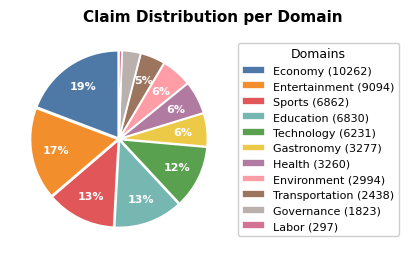

In [ ]:
# Create aesthetic pie chart for super domain distribution - ACL single column format
fig, ax = plt.subplots(figsize=(4, 3.2))

# Sort domains by count for better visualization
sorted_domains = sorted(super_domain_count.items(), key=lambda x: x[1], reverse=True)
labels = [d[0] for d in sorted_domains]
sizes = [d[1] for d in sorted_domains]
total = sum(sizes)

# Beautiful color palette (11 distinct colors)
colors = [
    '#4E79A7',  # Media - steel blue
    '#F28E2B',  # Economies - orange
    '#E15759',  # Sports - coral red
    '#76B7B2',  # Technology - teal
    '#59A14F',  # Education - green
    '#EDC948',  # Health - gold
    '#B07AA1',  # Food - purple
    '#FF9DA7',  # Environment - pink
    '#9C755F',  # Transportation - brown
    '#BAB0AC',  # Governance - gray
    '#D37295',  # Labor - rose
]

# Only show percentage labels for slices > 4%
def autopct_func(pct):
    return f'{pct:.0f}%' if pct > 4 else ''

# Create pie chart
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=None,
    autopct=autopct_func,
    colors=colors,
    startangle=90,
    pctdistance=0.72,
    explode=[0.015] * len(sizes),
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.2}
)

# Style the percentage text
for autotext in autotexts:
    autotext.set_fontsize(8)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

# Create legend with percentages
legend_labels = [f'{label} ({count})' for label, count in sorted_domains]
ax.legend(
    wedges, 
    legend_labels,
    title="Domains",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=8,
    title_fontsize=9,
    framealpha=0.95
)

#ax.set_title('Claim Distribution by Domain', fontsize=11, fontweight='bold', pad=8)
ax.set_title("")  # remove axis title
fig.suptitle(
    'Claim Distribution per Domain',
    fontsize=11,
    fontweight='bold',
    x=0.56,          # force horizontal center
    y=0.85          # vertical position
)
plt.tight_layout()
plt.savefig(config.paper_plots_dir / 'super_domain_distribution_pie.pdf', bbox_inches='tight')
plt.show()

#### Analytic Domains and Subdomains Latex

In [ ]:
# Generate LaTeX table for appendix
print("\\begin{table}[h]")
print("\\centering")
print("\\small")
print("\\begin{tabular}{l|l}")
print("\\toprule")
print("\\textbf{Domain} & \\textbf{Subdomains} \\\\")
print("\\midrule")

for super_d, sub_domains in SUPER_DOMAIN.items():
    subs = ", ".join(sub_domains)
    print(f"{super_d} & {subs} \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\caption{Domain taxonomy: 11 domains composed of 30+ subdomains.}")
print("\\end{table}")

\begin{table}[h]
\centering
\small
\begin{tabular}{l|l}
\toprule
\textbf{Domain} & \textbf{Subdomains} \\
\midrule
Entertainment & Movies, Music, TV Shows, Games, Cartoons \\
Technology & Software, IT, Blockchain, Vision \\
Education & University, Academia, Schools, Language, Books \\
Health & Healthcare, Medical, Biology, Chemistry \\
Economy & Finance, World Economies, Retail, Banking \\
Transportation & Transit Systems, Airport \\
Gastronomy & Food, Restaurant \\
Governance & Crime, Law \\
Environment & Weather, Geography \\
Labor & Human Resources \\
Sports & Basketball, Olympics, Hockey, F1, Soccer \\
\bottomrule
\end{tabular}
\caption{Domain taxonomy: 11 domains composed of 30+ subdomains.}
\end{table}


In [ ]:
# Simpler version without multirow - with escaped underscores
print("\\begin{table*}[t]")
print("\\centering")
print("\\small")
print("\\begin{tabular}{lll}")
print("\\toprule")
print("\\textbf{Domain} & \\textbf{Subdomain} & \\textbf{Databases} \\\\")
print("\\midrule")

for super_d, sub_domains in SUPER_DOMAIN.items():
    for i, sub_d in enumerate(sub_domains):
        databases = DOMAIN_TO_DATABASES.get(sub_d, [])
        if sub_d == 'Sports': maximum = 5
        else: maximum = 8
        if databases:
            # Escape underscores for LaTeX
            escaped_dbs = [db.replace("_", "\\_") for db in databases[:maximum]]
            db_str = ", ".join([f"\\texttt{{{db}}}" for db in escaped_dbs])
            if len(databases) > maximum:
                db_str += f", ... (+{len(databases)-maximum})"
            
            domain_col = super_d if i == 0 else ""
            print(f"{domain_col} & {sub_d} & {db_str} \\\\")
    print("\\cmidrule{2-3}")

print("\\bottomrule")
print("\\end{tabular}")
print("\\caption{Domain taxonomy with representative databases (80 total across 11 domains and 36 subdomains).}")
print("\\label{tab:domain_taxonomy}")
print("\\end{table*}")

\begin{table*}[t]
\centering
\small
\begin{tabular}{lll}
\toprule
\textbf{Domain} & \textbf{Subdomain} & \textbf{Databases} \\
\midrule
Entertainment & Movies & \texttt{movie}, \texttt{movie\_3}, \texttt{movie\_platform}, \texttt{movies}, \texttt{movies\_4}, \texttt{movielens} \\
 & Music & \texttt{music}, \texttt{music\_tracker}, \texttt{music\_platform\_2} \\
 & TV Shows & \texttt{law\_episode} \\
 & Games & \texttt{video\_games}, \texttt{card\_games} \\
 & Cartoons & \texttt{simpson\_episodes}, \texttt{superhero}, \texttt{disney} \\
\cmidrule{2-3}
Technology & Software & \texttt{talkingdata}, \texttt{codebase\_community}, \texttt{codebase\_comments}, \texttt{social\_media}, \texttt{software\_company} \\
 & IT & \texttt{public\_review\_platform}, \texttt{app\_store} \\
 & Blockchain & \texttt{coinmarketcap} \\
 & Vision & \texttt{image\_and\_language} \\
\cmidrule{2-3}
Education & University & \texttt{student\_club}, \texttt{university}, \texttt{cs\_semester}, \texttt{college\_comple

## Inest Nulls

In [ ]:
with open(config.final_benchmark_dir / 'test-private-claimdb.jsonl', 'r') as f:
    private_claimdb = [json.loads(line) for line in f.readlines()]

with open(config.final_benchmark_dir / 'BIRD-source.jsonl', 'r') as f:
    bird_source = [json.loads(line) for line in f.readlines()]

with open(config.final_benchmark_dir / 'BIRD-source.jsonl', 'r') as f:
    bird_lines = [line for line in f]
whoops = []

for bird, line in zip(bird_source, bird_lines):
    if 'null' in line:
        whoops.append(bird)
p_ids = [entry['bird_id'] for entry in private_claimdb]

len(p_ids)
for w in whoops:
    #print(w['bird_id'])
    for entry in private_claimdb:
        if entry['bird_id'] == w['bird_id']:
            print('"bird_id": {}'.format(w['bird_id']))
            print('"claim_id": {}'.format(entry['claim_id']))
            print()


## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()